In [56]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# UPLOAD THE DATASET FROM PC

try:
    df = pd.read_csv('Startup_Scoring_Dataset.csv')
    print("DATASET LOADED")
    print("\nDataset Info:")
    df.info()
except FileNotFoundError:
    print("Error: File not found.")
    print("Upload the file to your Colab environment or provide the correct path.")
    exit()

DATASET LOADED

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   startup_id               100 non-null    object
 1   team_experience          100 non-null    int64 
 2   market_size_million_usd  100 non-null    int64 
 3   monthly_active_users     100 non-null    int64 
 4   monthly_burn_rate_inr    100 non-null    int64 
 5   funds_raised_inr         100 non-null    int64 
 6   valuation_inr            100 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 5.6+ KB


Data Preprocessing

In [57]:
# Positive Features
positive_features = [
    'team_experience',
    'market_size_million_usd',
    'monthly_active_users',
    'funds_raised_inr',
    'valuation_inr'
]

# Negative Features
negative_features = [
    'monthly_burn_rate_inr'
]

# Min-Max Normalization
scaler = MinMaxScaler()

for feature in positive_features:
    df[f'normalized_{feature}'] = scaler.fit_transform(df[[feature]])
    print(f"Normalized '{feature}'")

for feature in negative_features:
    normalized_val = scaler.fit_transform(df[[feature]])
    # Invert negative features since they are negatively correlated
    df[f'normalized_{feature}'] = 1 - normalized_val
    print(f"\nNormalized and inverted '{feature}'")

Normalized 'team_experience'
Normalized 'market_size_million_usd'
Normalized 'monthly_active_users'
Normalized 'funds_raised_inr'
Normalized 'valuation_inr'

Normalized and inverted 'monthly_burn_rate_inr'


Scoring Formula

In [58]:
# Assign weights
weights = {
    'normalized_team_experience': 0.15,
    'normalized_market_size_million_usd': 0.20,
    'normalized_monthly_active_users': 0.30,
    'normalized_monthly_burn_rate_inr': 0.10,
    'normalized_funds_raised_inr': 0.10,
    'normalized_valuation_inr': 0.15
}

print("Assigned Weights:")
for feature, weight in weights.items():
    print(f" {feature}: {weight*100}%")

# Composite Score
df['composite_score'] = 0
for feature, weight in weights.items():
    df['composite_score'] += df[feature] * weight

# Out of 100
df['composite_score'] = df['composite_score'] * 100

print("\nSample scores:")
print(df[['startup_id', 'composite_score']].head())

Assigned Weights:
 normalized_team_experience: 15.0%
 normalized_market_size_million_usd: 20.0%
 normalized_monthly_active_users: 30.0%
 normalized_monthly_burn_rate_inr: 10.0%
 normalized_funds_raised_inr: 10.0%
 normalized_valuation_inr: 15.0%

Sample scores:
  startup_id  composite_score
0       S001        58.396760
1       S002        40.219878
2       S003        45.129637
3       S004        52.805209
4       S005        50.253407


Rank & Interpretation

In [59]:
# Ranking Startups
df_ranked = df.sort_values(by='composite_score', ascending=False).reset_index(drop=True)
df_ranked['rank'] = df_ranked.index + 1

print("\nTop 10 Startups:")
print(df_ranked[['rank', 'startup_id', 'composite_score'] + positive_features + negative_features].head(10))

print("\nBottom 10 Startups:")
print(df_ranked[['rank', 'startup_id', 'composite_score'] + positive_features + negative_features].tail(10))


print("\nInterpretation")

top_startup = df_ranked.iloc[0]
print(f"\nTop Startup (ID: {top_startup['startup_id']}, Score: {top_startup['composite_score']:.2f}):")
print("This startup scored very high due to:")
for feature in positive_features:
    print(f"  - High {feature.title()}: {top_startup[feature]:,.0f} (Normalized: {top_startup[f'normalized_{feature}']:.2f})")
for feature in negative_features:
    print(f"  - Low {feature.title()}: {top_startup[feature]:,.0f} (Normalized & Inverted: {top_startup[f'normalized_{feature}']:.2f})")
print("The strong performance across key metrics like monthly active users, market size, and team experience, combined with efficient burn rate, contributed significantly to its high score.")


bottom_startup = df_ranked.iloc[-1]
print(f"\nBottom Startup (ID: {bottom_startup['startup_id']}, Score: {bottom_startup['composite_score']:.2f}):")
print("This startup scored very low because of:")
for feature in positive_features:
    print(f"  - Low {feature.title()}: {bottom_startup[feature]:,.0f} (Normalized: {bottom_startup[f'normalized_{feature}']:.2f})")
for feature in negative_features:
    print(f"  - High {feature.title()}: {bottom_startup[feature]:,.0f} (Normalized & Inverted: {bottom_startup[f'normalized_{feature}']:.2f})")
print("Low monthly active users, smaller market size, and potentially high burn rate pulled its overall score down significantly.")



Top 10 Startups:
   rank startup_id  composite_score  team_experience  market_size_million_usd  \
0     1       S006        80.973030               10                      416   
1     2       S077        76.753775                9                      357   
2     3       S045        76.346062               10                      743   
3     4       S013        74.525413                8                      735   
4     5       S029        74.184803                7                      804   
5     6       S033        73.195233                5                      867   
6     7       S097        72.061303                9                      686   
7     8       S082        70.741360                9                      394   
8     9       S043        69.953881               10                      105   
9    10       S066        69.837226               10                      655   

   monthly_active_users  funds_raised_inr  valuation_inr  \
0                 95939       

Visualization

/tmp/ipython-input-60-2383988942.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='startup_id', y='composite_score', data=df_ranked, palette='inferno')


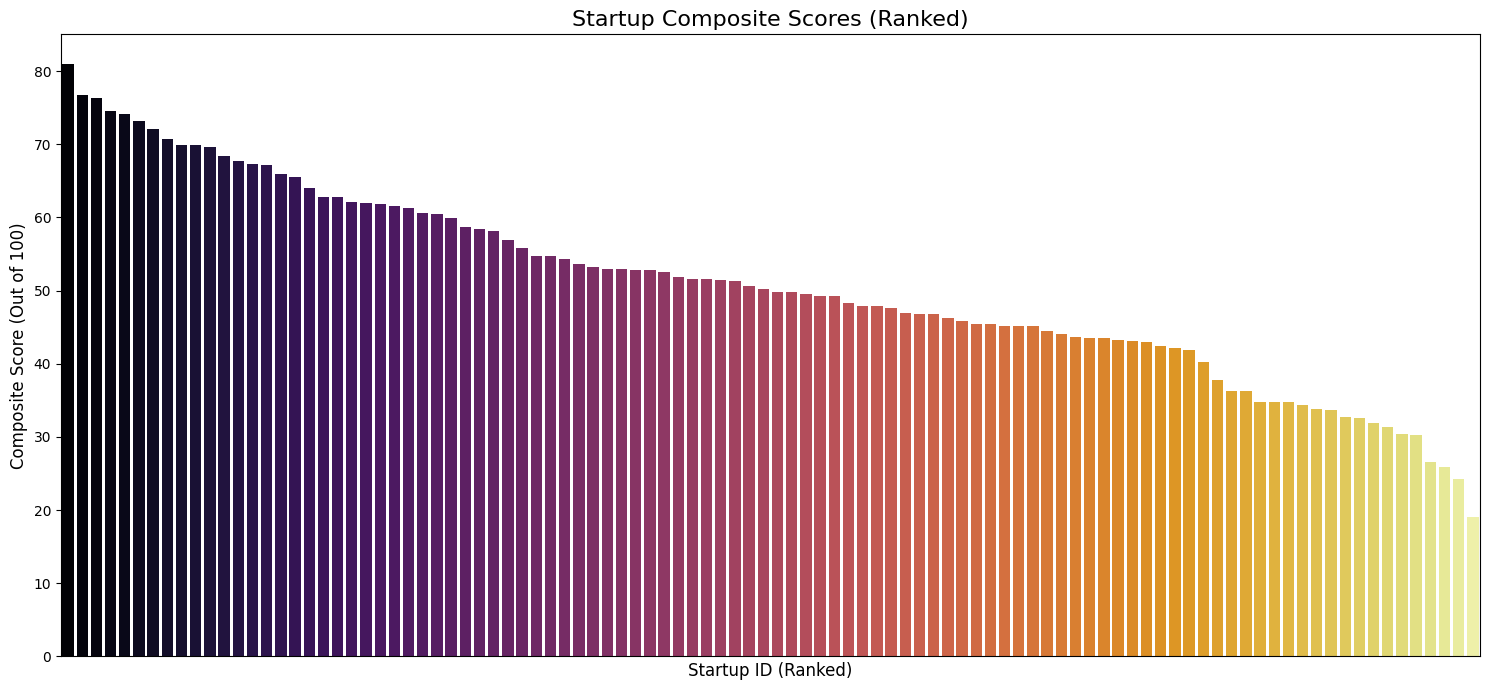

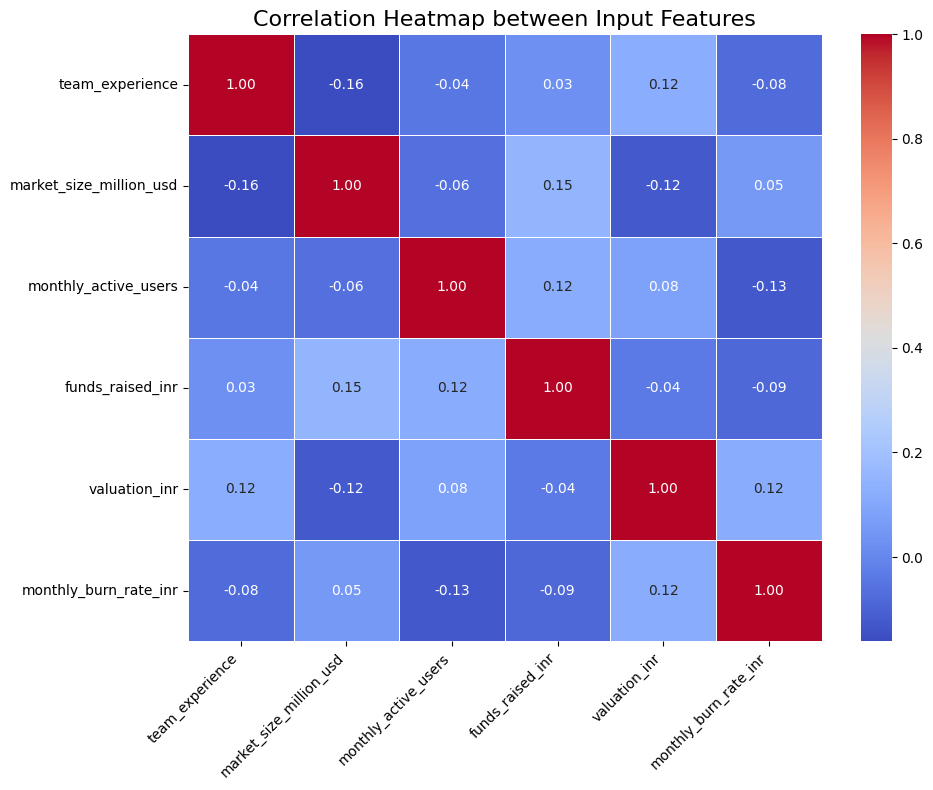

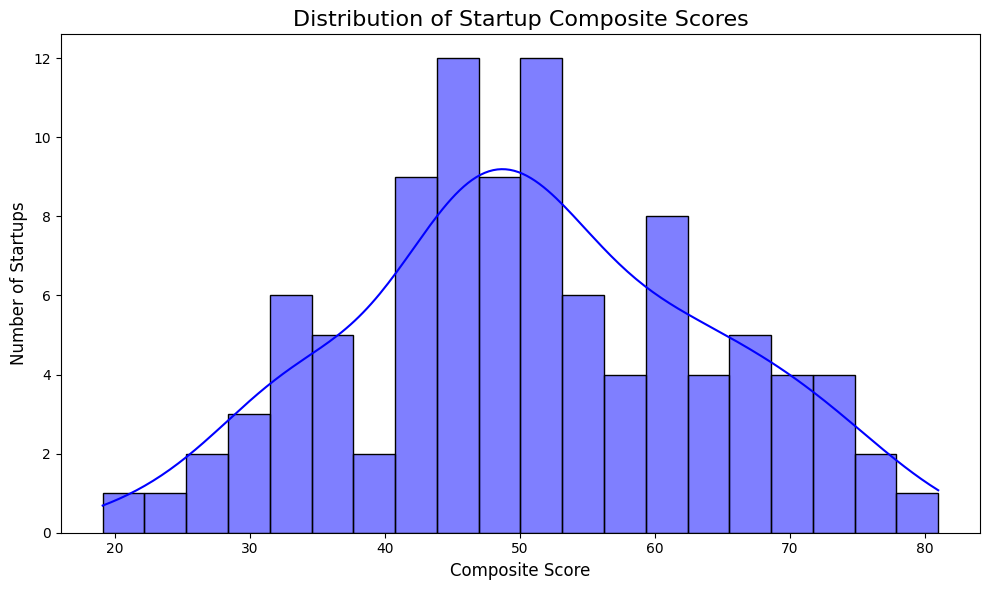

In [60]:
# Bar Chart (Sorted)
plt.figure(figsize=(15, 7))
sns.barplot(x='startup_id', y='composite_score', data=df_ranked, palette='inferno')
plt.title('Startup Composite Scores (Ranked)', fontsize=16)
plt.xlabel('Startup ID (Ranked)', fontsize=12)
plt.ylabel('Composite Score (Out of 100)', fontsize=12)
plt.xticks([])
plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 8))
numeric_cols = positive_features + negative_features
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap between Input Features', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# Score Distribution Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_ranked['composite_score'], bins=20, kde=True, color='blue')
plt.title('Distribution of Startup Composite Scores', fontsize=16)
plt.xlabel('Composite Score', fontsize=12)
plt.ylabel('Number of Startups', fontsize=12)
plt.tight_layout()
plt.show()


Documentation

In [61]:
"""
Startup Health Scoring Model

The given task outlines the methodology used to create a composite health score for 100 startups, similar to a credit score.
The goal is to evaluate startup potential based on the indicators provided in the dataset.

  1. Data Preprocessing and Normalization

The first step involved loading the `Startup_Scoring_Dataset.csv`.
To ensure fair comparison across features with different scales, all numeric columns were normalized to a 0-1 range using Min-Max Scaling.

Handling Negatively Correlated Metrics:

For monthly_burn_rate_inr, where a lower value indicates a better outcome which means less money spent, all values in that column were inverted.
After normalizing monthly_burn_rate_inr to a 0-1 range, the normalized value was subtracted from 1 (`1 - normalized_burn_rate`). This transformation ensures that:
- A very low burn rate (good) results in a normalized value close to 1.
- A very high burn rate (bad) results in a normalized value close to 0.
This aligns its contribution positively with the overall composite score, meaning a higher inverted normalized burn rate contributes more positively to the final score.

  2. Custom Scoring Formula and Feature Weighting

A custom scoring formula was designed to generate a composite score out of 100. This formula is a weighted sum of the normalized features.
The choice of weights reflects my assessment of each feature's importance in determining a startup's potential:

- Monthly Active Users (0.30): Given the highest weight. This metric is a direct indicator of product-market fit, user engagement,
and traction, which are often the most critical factors for early-stage startup success and future growth.

- Market Size (0.20): A larger, more accessible market is crucial for scalability and long-term growth potential. Even with a great product, a small market limits ultimate success.

- Team Experience (0.15): A strong team is fundamental. Experienced founders are more likely to navigate through hardships, and execute their vision effectively.

- Valuation (0.15): Reflects market perception and investor confidence. A higher valuation generally indicates external validation of potential.

- Funds Raised (0.10): Indicates investor confidence and provides the necessary power for operations and growth.
However it's less important than actual traction or market size as money alone doesn't guarantee success.

- Monthly Burn Rate (0.10, inverted): Startups will initially have a higher burn rate and cannot be a good indicator of success in early stages. Hence it has a lower weight.


  3. Ranking and Interpretation

All 100 startups were ranked based on their calculated composite scores.

Insights:

The top-performing startups typically exhibited a strong combination of high monthly active users, large market size, and experienced teams, coupled with reasonable burn rates.
Conversely, the bottom-performing startups often showed deficiencies in these key areas. A startup with low monthly active users, a small market, and potentially a high burn rate would naturally rank very low.
The ranking clearly highlights that traction (monthly active users) and market potential are highly influential in this scoring model, reflecting their importance in real-world startup evaluation.

  4. Visualizations

- Bar Chart: Provides a clear visual representation of the score distribution across all startups, making it easy to see the range and identify clusters of high/low performers.
- Correlation Heatmap: Shows the relationships between the original input features. This can reveal if funds raised are highly correlated with valuation, or if team experience correlates with market size.
- Score Distribution Histogram: Illustrates how the composite scores are distributed. It helps understand if scores are clustered around an average or if there are distinct groups of high and low scorers.

Conclusion

This model provides a foundational framework for startup scoring. The choice of weights and the handling of negative metrics are critical design decisions that can be refined.
If available, incorporating time-series data for metrics like burn rate could allow for analysis of trends and growth trajectories, which are crucial for dynamic startup evaluation.

"""


"\nStartup Health Scoring Model\n\nThe given task outlines the methodology used to create a composite health score for 100 startups, similar to a credit score. \nThe goal is to evaluate startup potential based on the indicators provided in the dataset.\n\n  1. Data Preprocessing and Normalization\n\nThe first step involved loading the `Startup_Scoring_Dataset.csv`. \nTo ensure fair comparison across features with different scales, all numeric columns were normalized to a 0-1 range using Min-Max Scaling.\n\nHandling Negatively Correlated Metrics:\n\nFor monthly_burn_rate_inr, where a lower value indicates a better outcome which means less money spent, all values in that column were inverted. \nAfter normalizing monthly_burn_rate_inr to a 0-1 range, the normalized value was subtracted from 1 (`1 - normalized_burn_rate`). This transformation ensures that:\n- A very low burn rate (good) results in a normalized value close to 1.\n- A very high burn rate (bad) results in a normalized value c